In [188]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import matplotlib.pyplot as plt

In [189]:

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [190]:
# preset paths
path = "D:\gdw\Foods"

path_pizza = "D:\gdw\Foods\pizza"
path_non_pizza = "D:\gdw\Foods\\non_pizza"
# image attributes
batch_size = 32
img_height = 220
img_width = 220
# train and validation seperate datasets
train_dataset = tf.keras.utils.image_dataset_from_directory(path,validation_split=0.2,subset="training",seed=524,image_size=(img_height, img_width),batch_size=batch_size)
validation_dataset = tf.keras.utils.image_dataset_from_directory(path,validation_split=0.2,subset="validation",seed=524,image_size=(img_height, img_width),batch_size=batch_size)

class_names = train_dataset.class_names

Found 1600 files belonging to 2 classes.
Using 1280 files for training.
Found 1600 files belonging to 2 classes.
Using 320 files for validation.


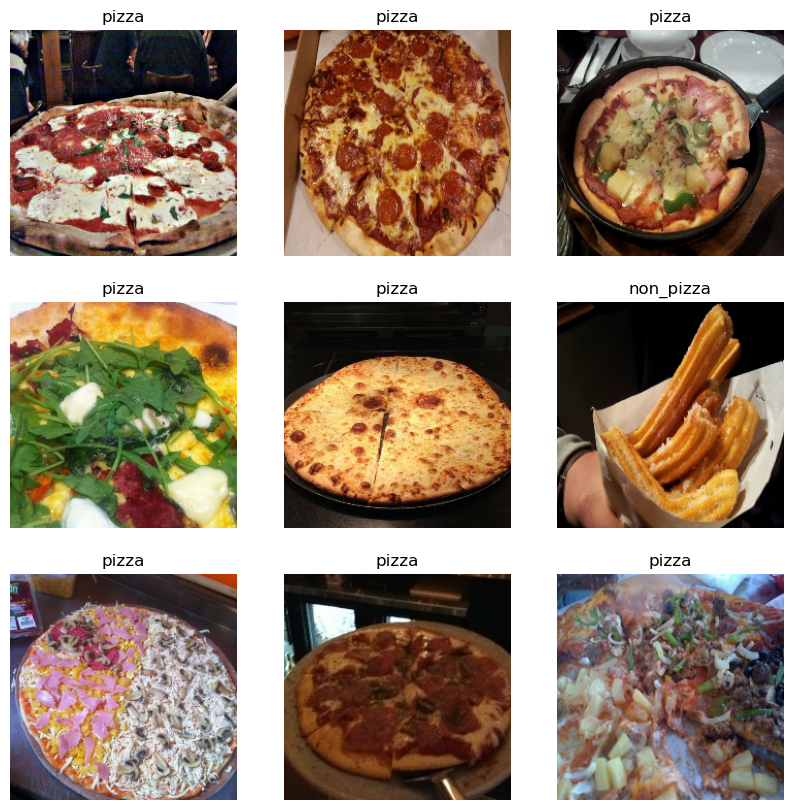

In [191]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_train[labels[i]])
    plt.axis("off")

View the pictures

In [192]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [193]:
normalization_layer = layers.Rescaling(1./255)

In [194]:
normalized_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_dataset))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.074866205 0.86520106


In [195]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [196]:
model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_23 (Rescaling)    (None, 220, 220, 3)       0         
                                                                 
 conv2d_30 (Conv2D)          (None, 220, 220, 16)      448       
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 110, 110, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (None, 110, 110, 32)      4640      
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 55, 55, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 55, 55, 64)      

In [197]:
epochs=10
history = model.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs=epochs
)

Epoch 1/10
40/40 [==============================] - 8s 192ms/step - loss: 0.8840 - accuracy: 0.5164 - val_loss: 0.7013 - val_accuracy: 0.4781
Epoch 2/10
40/40 [==============================] - 7s 173ms/step - loss: 0.6749 - accuracy: 0.5852 - val_loss: 0.6573 - val_accuracy: 0.6313
Epoch 3/10
40/40 [==============================] - 8s 192ms/step - loss: 0.6298 - accuracy: 0.6500 - val_loss: 0.6177 - val_accuracy: 0.7094
Epoch 4/10
40/40 [==============================] - 7s 187ms/step - loss: 0.5977 - accuracy: 0.6867 - val_loss: 0.6028 - val_accuracy: 0.6969
Epoch 5/10
40/40 [==============================] - 8s 189ms/step - loss: 0.5345 - accuracy: 0.7422 - val_loss: 0.5776 - val_accuracy: 0.7156
Epoch 6/10
40/40 [==============================] - 7s 187ms/step - loss: 0.4689 - accuracy: 0.7883 - val_loss: 0.5782 - val_accuracy: 0.6938
Epoch 7/10
40/40 [==============================] - 8s 192ms/step - loss: 0.3638 - accuracy: 0.8406 - val_loss: 0.6220 - val_accuracy: 0.6875
Epoch 

View train results

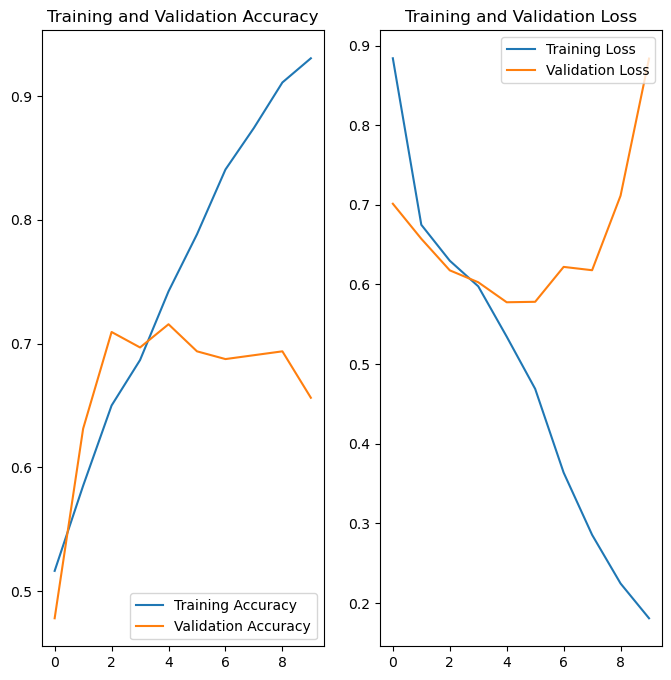

In [198]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [199]:
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
predictions = probability_model.predict(train_dataset)

40/40 [==============================] - 2s 52ms/step


In [200]:
# try the trustness of the model
np.argmax(predictions[67])

1

In [201]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

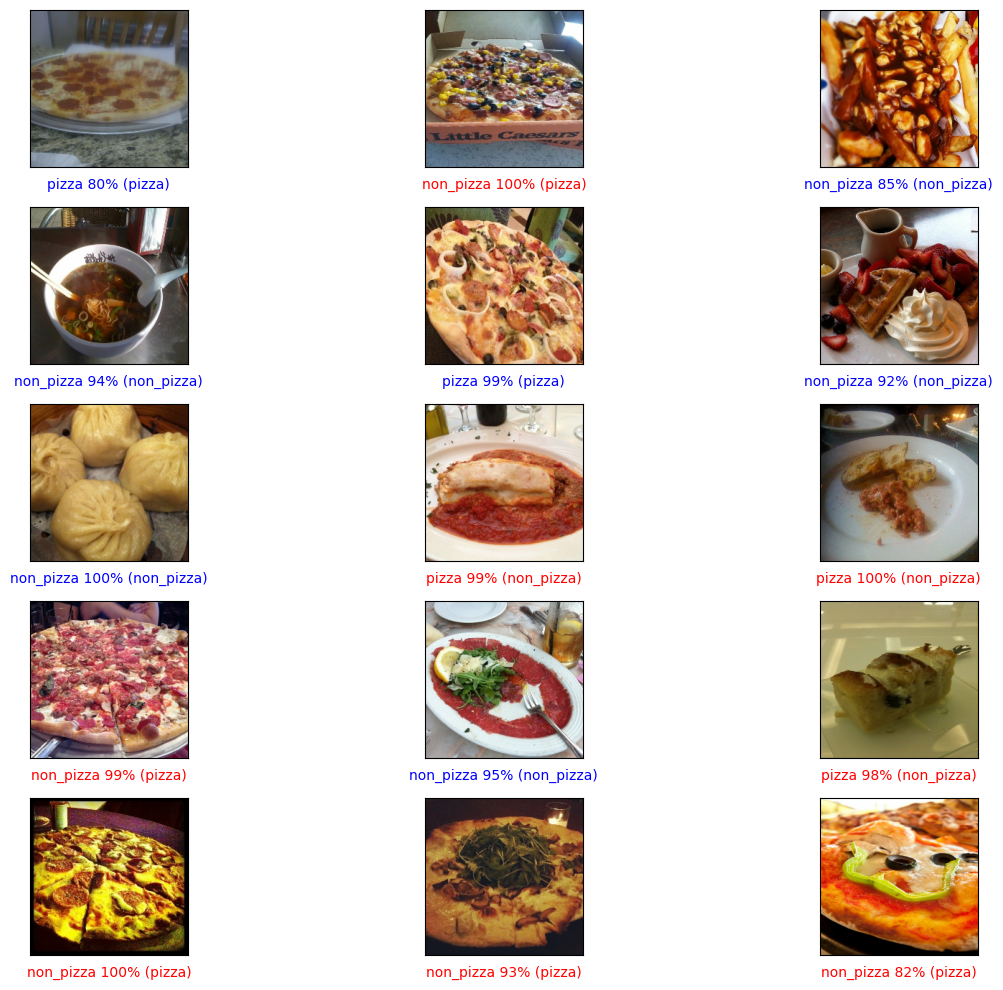

In [202]:
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], labels_batch, image_batch)
plt.tight_layout()
plt.show()

In [204]:
print('Very low accuracy,I guess the reason is that there are only two class called "pizza" and "non pizza".And there are too many possibilities in "non pizza" class!!!')




Very low accuracy,I guess the reason is that there are only two class called "pizza" and "non pizza".And there are too many possibilities in "non pizza" class!!!
